In [ ]:
## Step 1: Load and Explore the Dataset

We begin by loading the Titanic dataset and exploring the data using Pandas. This helps identify useful features, handle missing values, and plan preprocessing steps.

We will analyze:
- The structure of the dataset
- Basic statistics of each column
- Null values and their impact
- Correlation of features with survival

This step ensures we understand the data before modeling.


Training Data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   Na

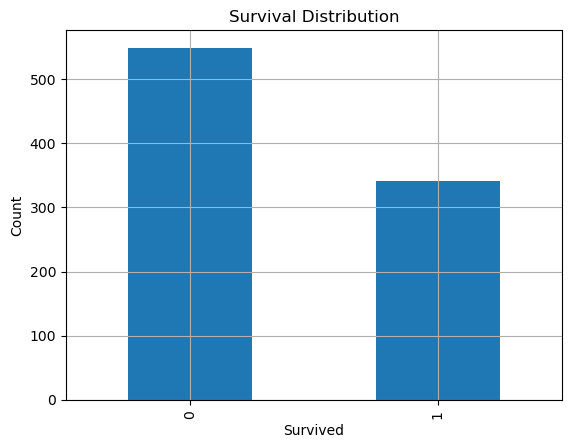

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_csv('/Users/harshilvadalia/Desktop/tp/titanic/train.csv')
test_df = pd.read_csv('/Users/harshilvadalia/Desktop/tp/titanic/test.csv')
submission_df = pd.read_csv('/Users/harshilvadalia/Desktop/tp/titanic/gender_submission.csv')

# Display the first few rows of the training data
print("Training Data:")
print(train_df.head())

# Basic info
print("\nDataset Info:")
print(train_df.info())

# Null value check
print("\nMissing Values:")
print(train_df.isnull().sum())

# Statistical summary
print("\nDescriptive Statistics:")
print(train_df.describe(include='all'))

# Target distribution
train_df['Survived'].value_counts().plot(kind='bar')
plt.title("Survival Distribution")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [ ]:
## Step 2: Data Preprocessing

Before training our models, we preprocess the data to handle:
- Missing values
- Categorical to numeric conversion
- Feature selection

This ensures the data is clean, consistent, and suitable for feeding into our custom ML algorithms.


Missing values after cleaning:
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


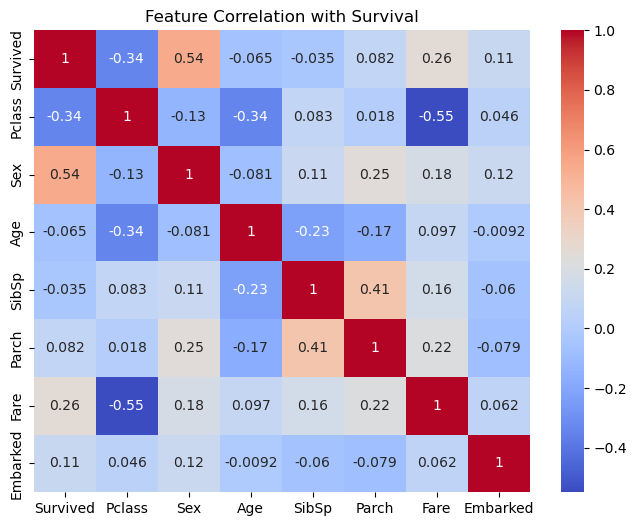

x_train shape: (891, 7)
y_train shape: (891,)


In [9]:
# Make a copy to avoid modifying original
df = train_df.copy()

# Drop features that are less useful or high cardinality
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Fill missing values
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])


# Convert categorical to numeric
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Confirm no nulls remain
print("Missing values after cleaning:")
print(df.isnull().sum())

# Plot correlation with survival
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Survival")
plt.show()

# Split into features and target
x_train = df.drop('Survived', axis=1).values
y_train = df['Survived'].values

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


In [ ]:
## Step 3: Naive Bayes Classifier (From Scratch)

We implement a Gaussian Naive Bayes classifier from scratch.

Key assumptions:
- Features are continuous and follow a Gaussian (normal) distribution.
- The algorithm computes class-wise mean and variance for each feature during training.
- During prediction, it uses the Gaussian probability density function to compute class likelihoods and selects the class with the highest posterior probability.


In [13]:
from collections import defaultdict
import numpy as np

class NaiveBayes:
    def fit(self, x, y):
        self.classes = np.unique(y)
        self.parameters = {}

        for c in self.classes:
            x_c = x[y == c]
            self.parameters[c] = {
                'mean': x_c.mean(axis=0),
                'var': x_c.var(axis=0) + 1e-6,  # avoid divide-by-zero
                'prior': x_c.shape[0] / x.shape[0]
            }

    def _gaussian_prob(self, class_idx, x):
        mean = self.parameters[class_idx]['mean']
        var = self.parameters[class_idx]['var']
        numerator = np.exp(- ((x - mean)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, x):
        predictions = []
        for sample in x:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.parameters[c]['prior'])
                class_conditional = np.sum(np.log(self._gaussian_prob(c, sample)))
                posterior = prior + class_conditional
                posteriors.append(posterior)
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)

# Train the model
nb = NaiveBayes()
nb.fit(x_train, y_train)

# Predict on training data
y_pred_nb = nb.predict(x_train)

# Accuracy
accuracy_nb = np.mean(y_pred_nb == y_train)
print(f"Naive Bayes Training Accuracy: {accuracy_nb:.4f}")


Naive Bayes Training Accuracy: 0.7924


In [ ]:
## Step 4: K-Nearest Neighbours (From Scratch)

K-Nearest Neighbours is a non-parametric, instance-based learning algorithm.

Steps:
1. Calculate the distance between a test point and all training points.
2. Pick the top K closest samples.
3. Use majority voting among these neighbors to classify the test point.

We use Euclidean distance as the distance metric.


In [21]:
import numpy as np
from collections import Counter

class KNearestNeighbours:
    def __init__(self, k=5):
        self.k = k

    def fit(self, x, y):
        self.x_train = x
        self.y_train = y

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, x_test):
        predictions = []
        for x in x_test:
            distances = [self._euclidean_distance(x, x_train) for x_train in self.x_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

# Find best k
def find_best_k(x_train, y_train, k_values):
    best_k = None
    best_accuracy = 0

    for k in k_values:
        knn = KNearestNeighbours(k=k)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_train)
        accuracy = np.mean(y_pred == y_train)
        print(f"k = {k}, Accuracy = {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k

    print(f"\n✅ Best k: {best_k} with Accuracy: {best_accuracy:.4f}")
    return best_k, best_accuracy

# Example usage
k_values = range(1, 21)  # Try k from 1 to 20
best_k, best_accuracy = find_best_k(x_train, y_train, k_values)

# Train final model with best k
knn = KNearestNeighbours(k=best_k)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_train)


k = 1, Accuracy = 0.9742
k = 2, Accuracy = 0.9742
k = 3, Accuracy = 0.8373
k = 4, Accuracy = 0.8923
k = 5, Accuracy = 0.8058
k = 6, Accuracy = 0.8541
k = 7, Accuracy = 0.7834
k = 8, Accuracy = 0.8260
k = 9, Accuracy = 0.7778
k = 10, Accuracy = 0.8148
k = 11, Accuracy = 0.7565
k = 12, Accuracy = 0.7991
k = 13, Accuracy = 0.7475
k = 14, Accuracy = 0.7800
k = 15, Accuracy = 0.7475
k = 16, Accuracy = 0.7744
k = 17, Accuracy = 0.7441
k = 18, Accuracy = 0.7710
k = 19, Accuracy = 0.7396
k = 20, Accuracy = 0.7587

✅ Best k: 1 with Accuracy: 0.9742


In [ ]:
## Step 5: Model Comparison and Visualization

In this step, we visualize the performance of both classifiers:

- Compare training accuracies
- Use a bar plot for clarity
- Visualize data distribution using PCA (bonus)
- Optional: Show where each model predicted correctly/incorrectly


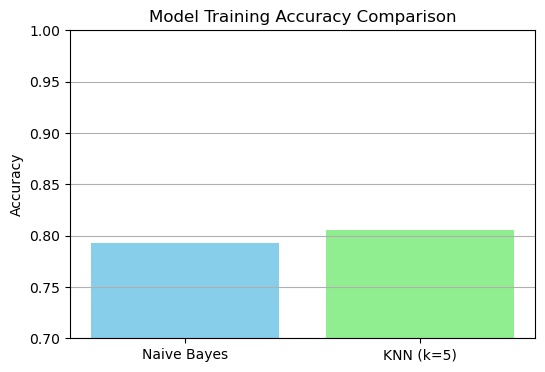

In [23]:
# Compare training accuracies
models = ['Naive Bayes', 'KNN (k=5)']
accuracies = [accuracy_nb, accuracy_knn]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Model Training Accuracy Comparison')
plt.ylim(0.7, 1.0)
plt.grid(True, axis='y')
plt.show()


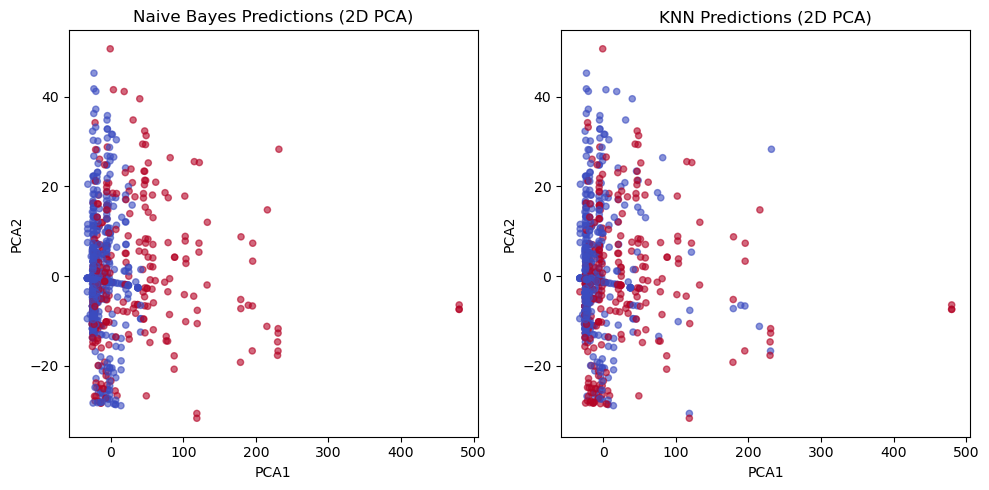

In [25]:
from sklearn.decomposition import PCA

# Reduce to 2D for plotting
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x_train)

plt.figure(figsize=(10, 5))

# Plot Naive Bayes predictions
plt.subplot(1, 2, 1)
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_pred_nb, cmap='coolwarm', s=20, alpha=0.6)
plt.title("Naive Bayes Predictions (2D PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Plot KNN predictions
plt.subplot(1, 2, 2)
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_pred_knn, cmap='coolwarm', s=20, alpha=0.6)
plt.title("KNN Predictions (2D PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.tight_layout()
plt.show()
